In [3]:
!pip install -U fastai

ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.0.1 which is incompatible.



  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19196 sha256=f99991c323620dd0a089ef276428b35e9f90d8a6f8d49cbff4dc722b4edcda69
  Stored in directory: c:\users\kwande\appdata\local\pip\cache\wheels\df\99\da\c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built nvidia-ml-py3


In [2]:
from fastai import *
from fastai.text import *
from pathlib import Path
import torch

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction import text
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

#new stuff
import keras
import codecs
import string
import re
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (ty

In [6]:
train = pd.read_csv('Train.csv', index_col='tweetid')

In [7]:
train.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [8]:
#preprocessing for the new stuff
#1 removing urls and changing to lower case.
#Substituting '@' with 'at' to track mentions
#changing hashtags into nor,mal words for tracking

#stop words
stop2 = text.ENGLISH_STOP_WORDS
stop = set(stopwords.words('english'))
stop_words = set((list(stop)+list(stop2)))
#lemmetize
def lemm(word):
    lemme = WordNetLemmatizer()
    result = lemme.lemmatize(word)
    return result

#remove stop words
def tokenizer_2(tokenized):
    tokenized = word_tokenize(tokenized)
    tokenized = [t for t in tokenized if (t not in  stop_words and len(t) > 1)]
    tokenized = [lemm(t) for t in tokenized]
    return tokenized

def clean_text(text):
    text2 = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "", text)
    no_punct = re.sub(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ",text2)
    text_men = re.sub(r"@", "at", no_punct)
    text_nonum = re.sub(r'\d+', '', text_men)
    text_cleaned = "".join([char.lower() for char in text_nonum if char not in string.punctuation])    
    return text_cleaned




In [9]:
train['cleaned'] = train['message'].apply(clean_text)
train['tokenized'] = train['cleaned'].apply(tokenizer_2)

In [10]:
train.head()

,sentiment,message,cleaned,tokenized
tweetid,,,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
126103,1,It's not like we lack evidence of anthropogeni...,its not like we lack evidence of anthropogenic...,"[like, lack, evidence, anthropogenic, global, ..."
698562,2,RT @RawStory: Researchers say we have three ye...,rt atrawstory researchers say we have three y...,"[rt, atrawstory, researcher, say, year, act, c..."
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,todayinmaker wired was a pivotal year in ...,"[todayinmaker, wired, pivotal, year, war, clim..."
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",rt atsoynoviodetodas its and a racist sexist...,"[rt, atsoynoviodetodas, racist, sexist, climat..."


In [112]:
train.groupby('sentiment').count()

,message,cleaned,tokenized
sentiment,,,
-1,1296,1296,1296
0,2353,2353,2353
1,8530,8530,8530
2,3640,3640,3640


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
def vectorizer(tokens):
    global vect
    emb = vect.fit_transform(tokens)
    return emb
x = train['cleaned'].to_list()
y = train['sentiment'].to_list()


In [117]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)

In [139]:
xtrain_vect = vectorizer(x_train)
xtest_vect = vect.transform(x_test)

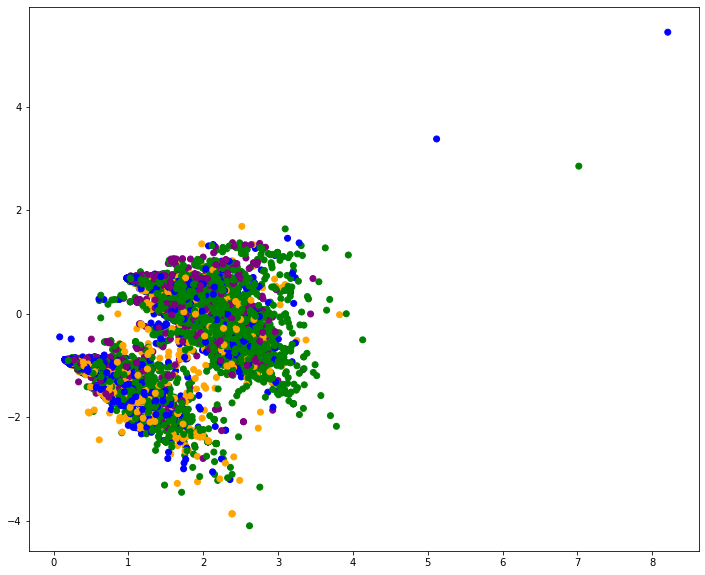

In [140]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
fig = plt.figure(figsize = (12,10))
lsa = TruncatedSVD(n_components = 4)
lsa.fit(xtrain_vect)
scores_train = lsa.transform(xtrain_vect)
color_mapper = {label:idx for idx,label in enumerate(set(y_train))}
color_column = [color_mapper[label] for label in y_train]
colors = ['orange','blue','green', 'purple']
plt.scatter(scores_train[:,0], scores_train[:,1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
#red_patch = mpatches.Patch(color='orange', label='Irrelevant')
#green_patch = mpatches.Patch(color='blue', label='Disaster')
#plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

plt.show()

In [160]:
#did a quick check using a different model to see what effect the data cleaning had. A lot faster than constantly having to run the transfer model after changes
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

clasif2 = Pipeline([(
                 'svm', SGDClassifier(alpha=1e-3, max_iter=50, random_state=32))])
clasif2 = clasif2.fit(xtrain_vect, y_train)


In [161]:
y_pred2 = clasif2.predict(xtest_vect)
print(y_pred2)

[ 2  1 -1  1 ...  1  1  1  1]


In [152]:
from sklearn.linear_model import LogisticRegression
clasif = LogisticRegression(solver = 'newton-cg',
                           multi_class = 'multinomial',
                           n_jobs = -1,
                           random_state = 32)

In [153]:
clasif.fit(xtrain_vect, y_train)

LogisticRegression(multi_class='multinomial', n_jobs=-1, random_state=32,
                   solver='newton-cg')

In [154]:
y_pred = clasif.predict(xtest_vect)
print(y_pred)

[ 2  1 -1  1 ...  1  1  1  1]


In [30]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


In [155]:
#precision Logistic
get_metrics(y_test, y_pred)

accuracy = 0.753, precision = 0.744, recall = 0.753, f1 = 0.744


In [162]:
#precision SGD
get_metrics(y_test, y_pred2)

accuracy = 0.735, precision = 0.726, recall = 0.735, f1 = 0.716


In [179]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.summer):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

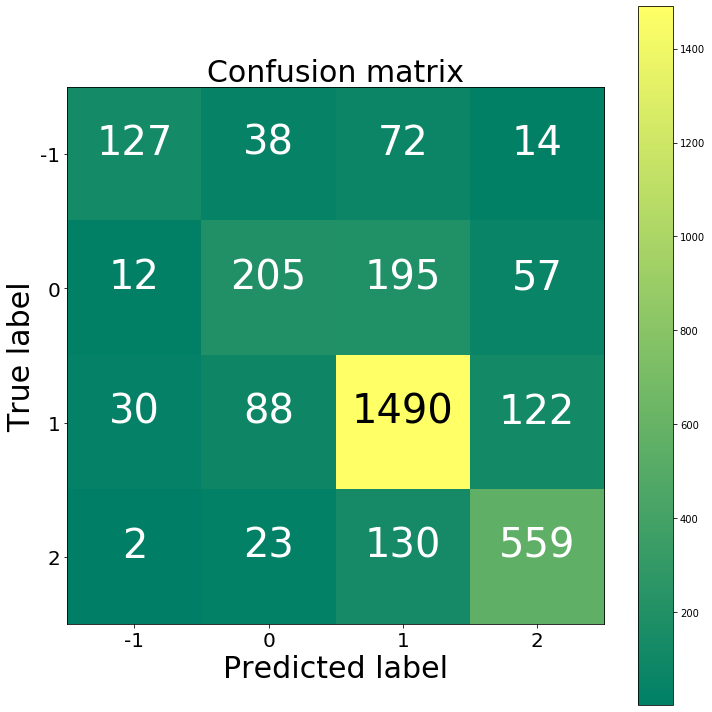

[[ 127   38   72   14]
 [  12  205  195   57]
 [  30   88 1490  122]
 [   2   23  130  559]]


In [180]:
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['-1',  '0', '1', '2'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

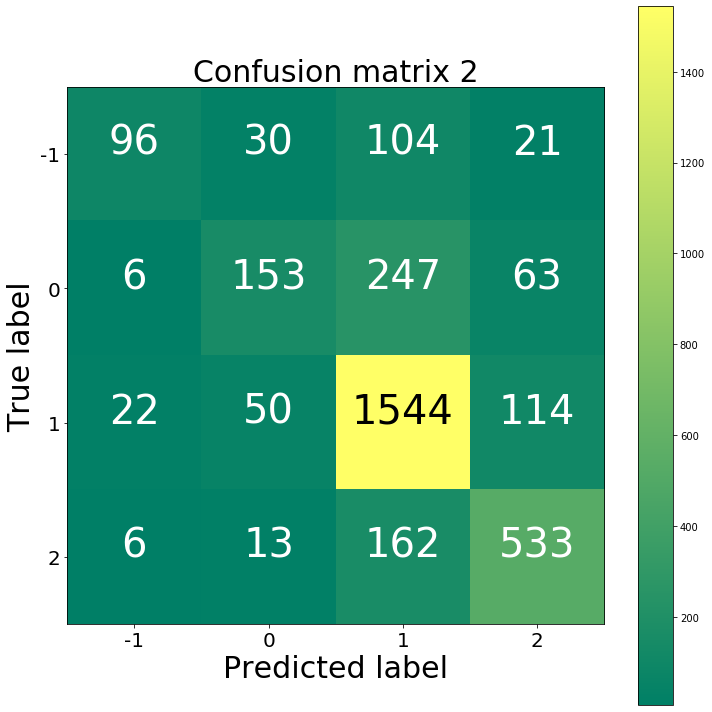

In [181]:
cm2 = confusion_matrix(y_test, y_pred2)
fig2 = plt.figure(figsize=(10, 10))
plot2 = plot_confusion_matrix(cm2, classes=['-1',  '0', '1', '2'], normalize=False, title='Confusion matrix 2')
plt.show()

In [189]:
#plotting most important features
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vect, clasif, 10)
print(importance)

{0: {'tops': [(1.4997897274179894, 'enlist'), (1.5177071751380138, 'lefties'), (1.5255309543608175, 'maga'), (1.5705810718146722, 'atclimatedepot'), (1.5893571895225858, 'atseanspicier'), (1.8402998793856868, 'tax'), (1.8901169554461774, 'liberals'), (2.216732071143301, 'alarmists'), (2.391655012948578, 'scam'), (2.495596953370206, 'atstevesgoddard')], 'bottom': [(-0.7508253116231927, 'scott'), (-0.7523568926324337, 'uk'), (-0.7560946704899861, 'address'), (-0.7788872687671973, 'thinks'), (-0.8132593933381861, 'could'), (-0.8442790343041101, 'thanks'), (-0.8468448747082205, 'effects'), (-0.9578303549889187, 'fight'), (-1.2950133210841952, 'china'), (-1.3164664018116228, 'competiti')]}, 1: {'tops': [(1.0834678927736052, 'checking'), (1.09876046005535, 'icebergs'), (1.1037932616392787, 'interesting'), (1.112120447116743, 'atknoctua'), (1.1218242080968852, 'atrepadamschiff'), (1.1364091135000214, 'thread'), (1.201203685794262, 'class'), (1.2762734793605637, 'penguin'), (1.295723815231863,

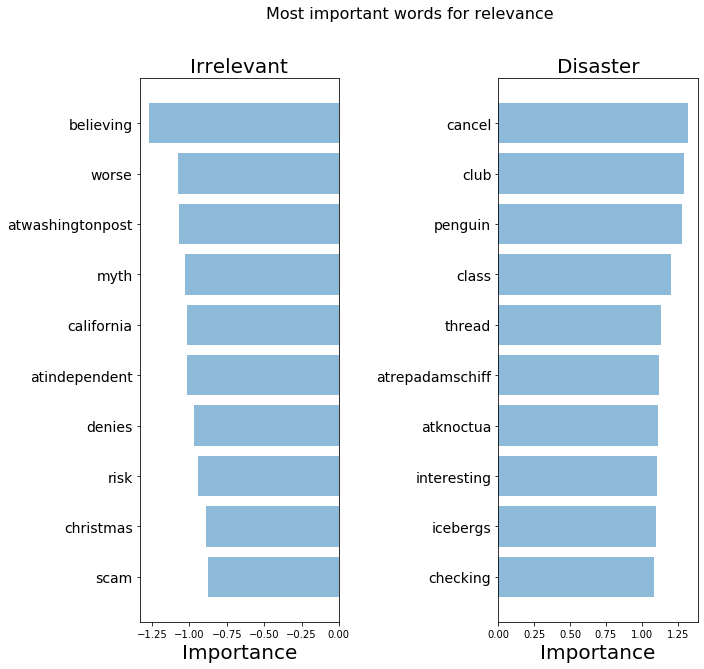

In [190]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [192]:
tf_vect = TfidfVectorizer()
xtrian_vect_tfidf = tf_vect.fit_transform(x_train)
xtest_vect_tfidf = tf_vect.transform(x_test)

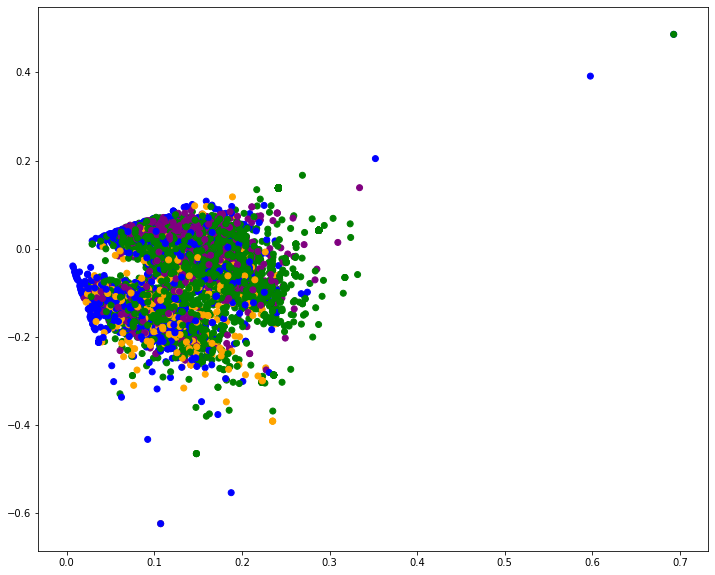

In [193]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
fig = plt.figure(figsize = (12,10))
lsa2 = TruncatedSVD(n_components = 4)
lsa2.fit(xtrian_vect_tfidf)
scores_train = lsa.transform(xtrian_vect_tfidf)
color_mapper = {label:idx for idx,label in enumerate(set(y_train))}
color_column = [color_mapper[label] for label in y_train]
colors = ['orange','blue','green', 'purple']
plt.scatter(scores_train[:,0], scores_train[:,1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
#red_patch = mpatches.Patch(color='orange', label='Irrelevant')
#green_patch = mpatches.Patch(color='blue', label='Disaster')
#plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

plt.show()

In [199]:
clasif.fit(xtrian_vect_tfidf,y_train)
y_tfidf = clasif.predict(xtest_vect_tfidf)
clasif2.fit(xtrian_vect_tfidf, y_train)
y_pred_3 = clasif2.predict(xtest_vect_tfidf)

In [197]:
get_metrics(y_test, y_tfidf)

accuracy = 0.741, precision = 0.738, recall = 0.741, f1 = 0.718


In [200]:
get_metrics(y_test, y_pred_3)

accuracy = 0.673, precision = 0.738, recall = 0.673, f1 = 0.606


In [3]:
import gensim

embedding_path = "glove.txt" 

def get_word2vec(file_path):
    file = open(embedding_path, "r", encoding = 'utf-8')
    if (file):
        word2vec = dict()
        split = file.read().splitlines()
        for line in split:
            key = line.split(' ',1)[0] # the first word is the key
            value = np.array([float(val) for val in line.split(' ')[1:]])
            word2vec[key] = value
        return (word2vec)
word2vec = get_word2vec(embedding_path)

In [34]:
from sklearn.model_selection import train_test_split
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=200):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokenized'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [35]:
embeddings = get_word2vec_embeddings(word2vec, train)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, y, 
                                                                                        test_size=0.2, random_state=32)

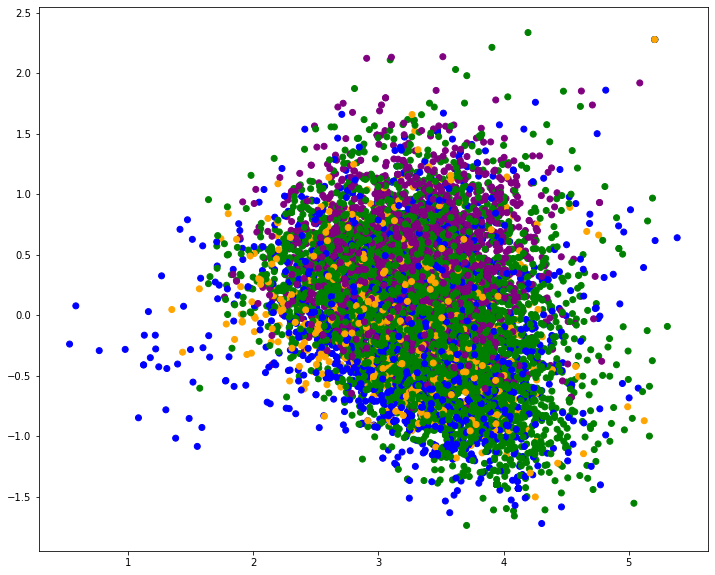

In [36]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
fig = plt.figure(figsize = (12,10))
lsaword = TruncatedSVD(n_components = 4)
lsaword.fit(X_train_word2vec)
scores_train = lsaword.transform(X_train_word2vec)
color_mapper = {label:idx for idx,label in enumerate(set(y_train_word2vec))}
color_column = [color_mapper[label] for label in y_train_word2vec]
colors = ['orange','blue','green', 'purple']
plt.scatter(scores_train[:,0], scores_train[:,1], c=y_train_word2vec, cmap=matplotlib.colors.ListedColormap(colors))
#red_patch = mpatches.Patch(color='orange', label='Irrelevant')
#green_patch = mpatches.Patch(color='blue', label='Disaster')
#plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

plt.show()

In [37]:
from sklearn.linear_model import LogisticRegression
clf_w2v = LogisticRegression(C=30.0, solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [38]:
get_metrics(y_test_word2vec, y_predicted_word2vec)

accuracy = 0.666, precision = 0.648, recall = 0.666, f1 = 0.647


In [40]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in train["tokenized"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in train["tokenized"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

173449 words total, with a vocabulary size of 21357
Max sentence length is 23


In [42]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 200
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train["cleaned"].tolist())
sequences = tokenizer.texts_to_sequences(train["cleaned"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(train["sentiment"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 23193 unique tokens.
(23194, 200)


In [70]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=-1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [71]:

x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(train["sentiment"].unique())), False)

In [72]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

ValueError: Error when checking target: expected dense_12 to have shape (4,) but got array with shape (3,)

In [7]:
#Preprocessing the data for topic modeeling reasons
#Not the final text cleaning. Created to see a rough output of what still neededc to be fiuxed befor a proper analysis is done on the returned results

#cleaning functions
from nltk.stem import WordNetLemmatizer

#stop words
stop2 = text.ENGLISH_STOP_WORDS
stop = set(stopwords.words('english'))

#create mention list
def m_fin(text):
    mentions = []
    men_f = re.compile(r'@([a-zA-Z0-9-z#_]+)')
    for word in text:
         mentions = men_f.findall(text)
    return mentions

#create hashtag list
def hash_finder(tweet):
    hashes = []
    finder = re.compile(r'#([a-zA-Z0-9-z#_]+)')
    for word in tweet:
        hashes = finder.findall(tweet)
    return hashes

#create url list
def url_fr(text):
    url = re.compile(r"([https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,}])")
    for link in text:
        found = url.findall(text)
    return found

#precleaning
def clean_text(text):
    text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "", text)

    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove 
    #text_nomen = re.sub(r'(@[a-zA-Z0-9-z#_]+)','', text_nonum)
    text_nohash = re.sub(r'(#[a-zA-Z0-9-z#_]+)', '', text_nonum)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nohash if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace

#lemmetize
def lemm(word):
    lemme = WordNetLemmatizer()
    result = lemme.lemmatize(word)
        #result = wordnet.morphy(word)
        #if result is None:
        #    return word
        #else: return result
    return result
#remove stop words
def tokenizer_2(tokenized):
    tokenized = word_tokenize(tokenized)
    tokenized = [t for t in tokenized if (t not in  stop and t not in stop2 and len(t) > 1)]
    tokenized = [lemm(t) for t in tokenized]
    return tokenized

#tweet word length
def counter(text):
    # remove numbers
    holder =[]
    holder = text.split()
    count = len(holder)
    return count
train['words'] =  train['message'].apply(counter)
train['tags'] = train['message'].apply(hash_finder)
train['url'] = train['message'].apply(url_fr)
train['cleaned'] = train['message'].apply(clean_text)
train['for_vect'] = train['cleaned'].apply(tokenizer_2)

In [13]:
#creating our corpus of words to use in our topic modelling algorithm
#rememebr to check tghe cleaning done to the text and the way inh wich they are tokenized as this will determine the corpus we create here
dictionary = Dictionary(train['for_vect'])
stopwords = stop.union(stop2, ['s'])
stop_ids =map(dictionary.token2id.get, stopwords)
dictionary.filter_tokens(stopwords)
dictionary.compactify()
dictionary.filter_extremes(no_below =2, no_above=5,keep_n=None)
dictionary.compactify()
corpus = [dictionary.doc2bow(doc) for doc in train['for_vect']]

#serializing corpus
MmCorpus.serialize('TweetCorp.mm', corpus)

#save dictionary
dictionary.save('TweetCorp.dict')

In [8]:
#test and train
from sklearn.model_selection import train_test_split
X, validation_x, Y, validation_y = train_test_split(train.cleaned, train.sentiment, test_size=0.30, shuffle = True, random_state=32)
train_text, test_text, train_val, test_val = train_test_split(X, Y, test_size=0.20, shuffle = True, random_state=32)



In [100]:
#did a quick check using a different model to see what effect the data cleaning had. A lot faster than constantly having to run the transfer model after changes
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

clasif = Pipeline([('vect', CountVectorizer(stop_words=stop2)),('tfid', TfidfTransformer()),(
                 'svm', SGDClassifier(loss='hinge', penalty ='l2', alpha=1e-3, max_iter=5, random_state=32))])
clasif = clasif.fit(train_text, train_val)
y_pred = clasif.predict(validation_x)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [18]:
y_pred

array([2, 1, 1, 1, ..., 1, 1, 1, 2], dtype=int64)

In [19]:
np.mean(y_pred == validation_y)

0.6609776654024442

In [24]:
#Created this supervised model where we chose an arbitasry amount of topics for the tweets. Done to check if we are getting reasonable results with the unsupervised model beelow
#creating LDA model for cat analysis
from sklearn.decomposition import LatentDirichletAllocation
# Build LDA Model
lda_model = models.ldamodel.LdaModel(corpus = corpus,
                                     id2word = dictionary,
                                     num_topics = 4,
                                     eval_every = 10,
                                     passes=50,
                                     iterations=5000,
                                     random_state=32)


In [25]:
#preparing the model for display
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data1 = gensimvis.prepare(lda_model, corpus, dictionary)

In [27]:
pyLDAvis.display(vis_data1)

In [30]:
#using an unsupervised Heirarchical Dirichlet Process model to determine topics
# The optional parameter T here indicates that HDP should find no more than 50 topics
# if there exists any.
hdp = models.hdpmodel.HdpModel(corpus, dictionary, T=50)
hdp.save('newsgroups_hdp.model')

In [31]:
vis_data = gensimvis.prepare(hdp, corpus, dictionary)
pyLDAvis.display(vis_data)

In [ ]:
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes


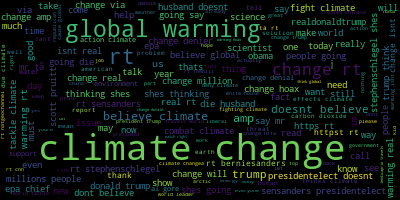

In [101]:
#quick analysis of the cleaned tweet data
from wordcloud import WordCloud

#strings we will wqork with from lemmetized text
analysis_strings = ','.join(list(train['cleaned'].values))

#WordCloud object
wc = WordCloud(background_color='black', max_words=200, contour_width=3,contour_color='steelblue')
wc.generate(analysis_strings)

#display created WordCloud
wc.to_image()

In [125]:
#plottig most common words
#lot of this comes from stackoverflow
def plotter(count_data, vectorizer):
    words_plot = vect.get_feature_names()
    total = np.zeros(len(words_plot))
    for t in count_data:
        total+=t.toarray()[0]
    count_dict = (zip(words_plot, total))
    count_dict = sorted(count_dict,key=lambda x:x[1],reverse=True)[0:20]
    words_plot = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words_plot))
    
    plt.figure(2, figsize=(10, 5))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words_plot, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

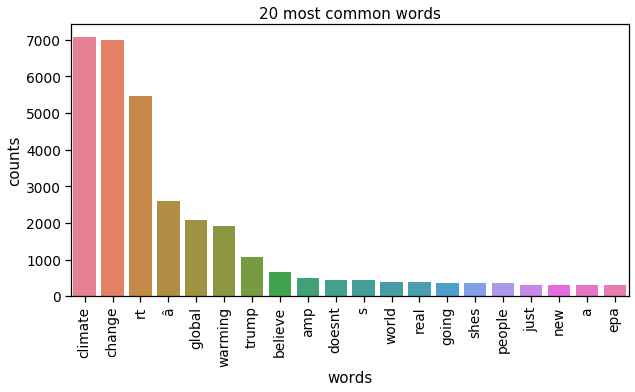

In [126]:
plotter(xtrain_vect, vect)

In [111]:
#vectorizing for lda using count vectorizer
vect = CountVectorizer(stop_words = stop2, analyzer = 'word', token_pattern=r'\w{1,}')
vect.fit(train['cleaned'])

xtrain_vect = vect.transform(train_text)
xvalid_vect = vect.transform(validation_x)
#x_val = t_vector.transform(test_text)

In [139]:
#quick topic modelling
#also extracting topics per tweet to bu used as features
#train LDA Model to start a quick topic analysis
from sklearn import decomposition
from sklearn.decomposition import *

lda_model = decomposition.LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=20)
tweet_topics= lda_model.fit(xtrain_vect)
found_topics= lda_model.components_
vocab = vect.get_feature_names()

#view k top topics
k = 10
topic_sum = []
for i, dist in enumerate(found_topics):
    found_topic = np.array(vocab)[np.argsort(dist)][:-(k+1):-1]
    topic_sum.append(''.join(found_topic))

In [140]:
#printing quick LDA tpoic model analysis results
#lda_model.fit(xtrain_vect)
#print(tweet_topics, vect, k)
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_model, vect, 10)

Topics found via LDA:

Topic #0:
planet good future exxon berniesanders tillerson used rex clinton discuss

Topic #1:
epa years pruitt scott hes head chief rights carbon denies

Topic #2:
https does said data youre manmade g debate literally role

Topic #3:
change climate rt new news trump research house white study

Topic #4:
global warming rt dont science think real make like realdonaldtrump

Topic #5:
climate change rt â trump believe doesnt s going shes

Topic #6:
climate change isnt help thing deniers report water did read

Topic #7:
making americans impacts thought public fucking huffpostpol having entire nice

Topic #8:
stop guardian story battle hell using opinion f invented chance

Topic #9:
new cause want ice leaders says evidence al arctic gore


In [141]:
!pip install pyLDAvis

  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97716 sha256=b2e9b5eb12798d4d3108a4c18fdcd385017e1f6453bb1287812fbf3e2c0bb361
  Stored in directory: c:\users\kwande\appdata\local\pip\cache\wheels\3b\fb\41\e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32045 sha256=627624b27bc1fc4cdb7fda4c31c24b1b14d1b8ea160b1b0686cc8f4419719d5e
  Stored in directory: c:\users\kwande\appdata\local\pip\cache\wheels\3c\33\97\805b282e129f60bb4e87cea622338f30b65f21eaf65219971f
Successfully built pyLDAvis funcy


In [144]:
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import pickle

In [146]:
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(10))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = sklearn_lda.prepare(lda_model, xtrain_vect, vect)
with open(LDAvis_data_filepath, 'w') as f:
    pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')


TypeError: write() argument must be str, not bytes